In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/anvesh232/grp_econ_busfor/refs/heads/main/health_dataset.csv')

In [ ]:
#data after this date data seems inconsisent as in skips 1 or 2 months and theres only one purchase order, so taking data until march 2023 only
df['Order.Date'] = pd.to_datetime(df['Order.Date'])
df = df[df['Order.Date'] <= pd.to_datetime("2023-03-17")]


In [ ]:
#organizing data by date(purchases and price for a given day are added)
df['Order.Date'] = pd.to_datetime(df['Order.Date'])
df['Title'] = df['Title'].fillna('').astype(str)
df['ASIN.ISBN..Product.Code.'] = df['ASIN.ISBN..Product.Code.'].fillna('').astype(str)
df['Category'] = df['Category'].fillna('').astype(str)

grouped_df = df.groupby(['Survey.ResponseID', 'Order.Date']).agg({
    'Purchase.Price.Per.Unit': 'sum',
    'Quantity': 'sum',
    'Title': ', '.join,
    'ASIN.ISBN..Product.Code.': ', '.join,
    'Category': ', '.join
}).reset_index()

grouped_df = grouped_df.sort_values(by=['Survey.ResponseID', 'Order.Date'])

In [ ]:
# for forecasting im adding the prices and no.of purchases for a given day
time_series_df = grouped_df.groupby('Order.Date').agg({
    'Purchase.Price.Per.Unit': 'sum',
    'Quantity': 'sum'
}).reset_index()

time_series_df.set_index('Order.Date', inplace=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/5icavegm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/rc65kiws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91837', 'data', 'file=/tmp/tmpxzflqyg_/5icavegm.json', 'init=/tmp/tmpxzflqyg_/rc65kiws.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model5ie5w4x5/prophet_model-20241216155552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


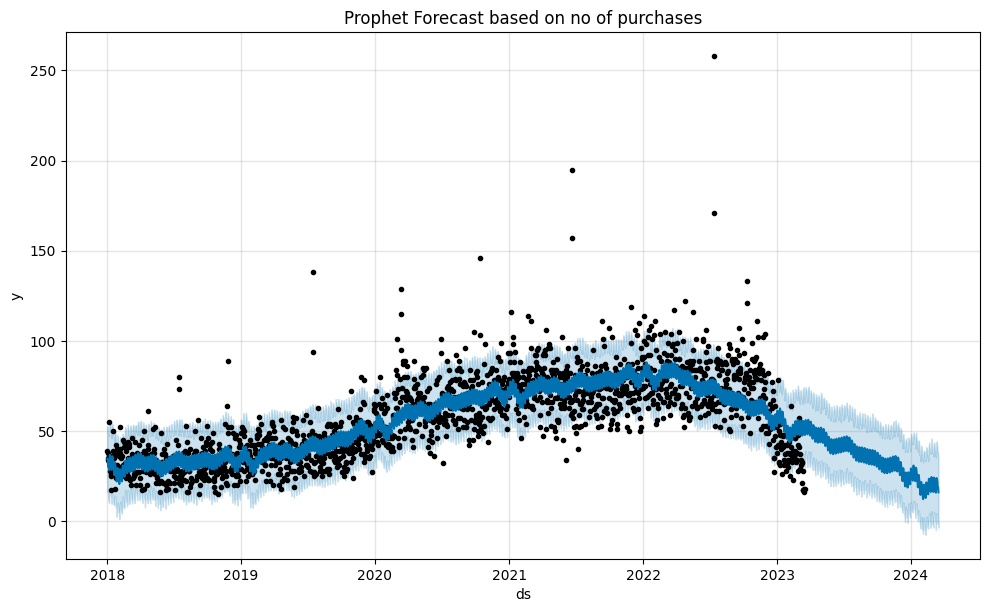

In [ ]:
#prophet based on no of purchases for a given day
from prophet import Prophet
import matplotlib.pyplot as plt
prophet_df = time_series_df.reset_index()[['Order.Date', 'Quantity']]
prophet_df.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=365) #we can chnage days by this line
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title('Prophet Forecast based on no of purchases')
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/fr3062au.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/ubqyu0p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30320', 'data', 'file=/tmp/tmpxzflqyg_/fr3062au.json', 'init=/tmp/tmpxzflqyg_/ubqyu0p2.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelilc6wrzr/prophet_model-20241216155601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


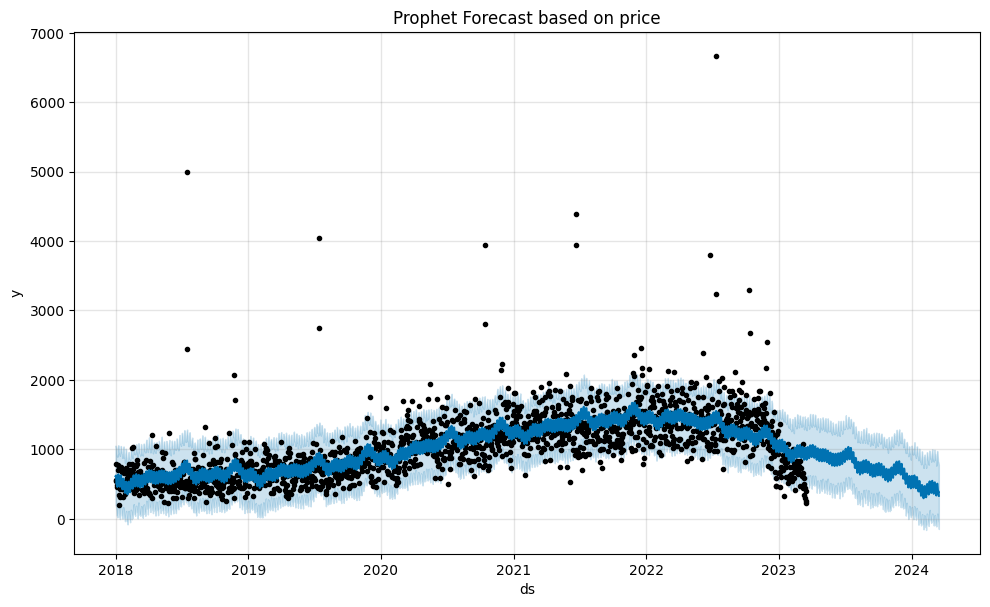

In [ ]:
#prophet based on total price for a given day
from prophet import Prophet
prophet_df = time_series_df.reset_index()[['Order.Date', 'Purchase.Price.Per.Unit']]
prophet_df.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=365)

forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title('Prophet Forecast based on price')
plt.show()


In [ ]:
#combining the surevy data with purchases and quantiy data
survey= pd.read_csv('https://raw.githubusercontent.com/anvesh232/grp_econ_busfor/refs/heads/main/survey.csv')
survey.rename(columns={
    'Survey ResponseID': 'Survey.ResponseID','Q-demos-age': 'Q.demos.age','Q-demos-hispanic': 'Q.demos.hispanic','Q-demos-race': 'Q.demos.race','Q-demos-education': 'Q.demos.education','Q-demos-income': 'Q.demos.income','Q-demos-gender': 'Q.demos.gender','Q-sexual-orientation': 'Q.sexual.orientation','Q-demos-state': 'Q.demos.state','Q-amazon-use-howmany': 'Q.amazon.use.howmany','Q-amazon-use-hh-size': 'Q.amazon.use.hh.size','Q-amazon-use-how-oft': 'Q.amazon.use.how.oft','Q-substance-use-cigarettes': 'Q.substance.use.cigarettes','Q-substance-use-marijuana': 'Q.substance.use.marijuana','Q-substance-use-alcohol': 'Q.substance.use.alcohol','Q-personal-diabetes': 'Q.personal.diabetes','Q-personal-wheelchair': 'Q.personal.wheelchair','Q-life-changes': 'Q.life.changes','Q-sell-YOUR-data': 'Q.sell.YOUR.data','Q-sell-consumer-data': 'Q.sell.consumer.data','Q-small-biz-use': 'Q.small.biz.use','Q-census-use': 'Q.census.use','Q-research-society': 'Q.research.society'
}, inplace=True)
combined_data = df.merge(survey, how='left', on='Survey.ResponseID')

In [ ]:
combined_data.columns

Index(['Order.Date', 'Purchase.Price.Per.Unit', 'Quantity',
       'Shipping.Address.State', 'Title', 'ASIN.ISBN..Product.Code.',
       'Category', 'Survey.ResponseID', 'Q.demos.age', 'Q.demos.hispanic',
       'Q.demos.race', 'Q.demos.education', 'Q.demos.income', 'Q.demos.gender',
       'Q.sexual.orientation', 'Q.demos.state', 'Q.amazon.use.howmany',
       'Q.amazon.use.hh.size', 'Q.amazon.use.how.oft',
       'Q.substance.use.cigarettes', 'Q.substance.use.marijuana',
       'Q.substance.use.alcohol', 'Q.personal.diabetes',
       'Q.personal.wheelchair', 'Q.life.changes', 'Q.sell.YOUR.data',
       'Q.sell.consumer.data', 'Q.small.biz.use', 'Q.census.use',
       'Q.research.society'],
      dtype='object')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/tyrgrb71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/_pe9o302.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27994', 'data', 'file=/tmp/tmpxzflqyg_/tyrgrb71.json', 'init=/tmp/tmpxzflqyg_/_pe9o302.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model7lwejmj6/prophet_model-20241216155619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


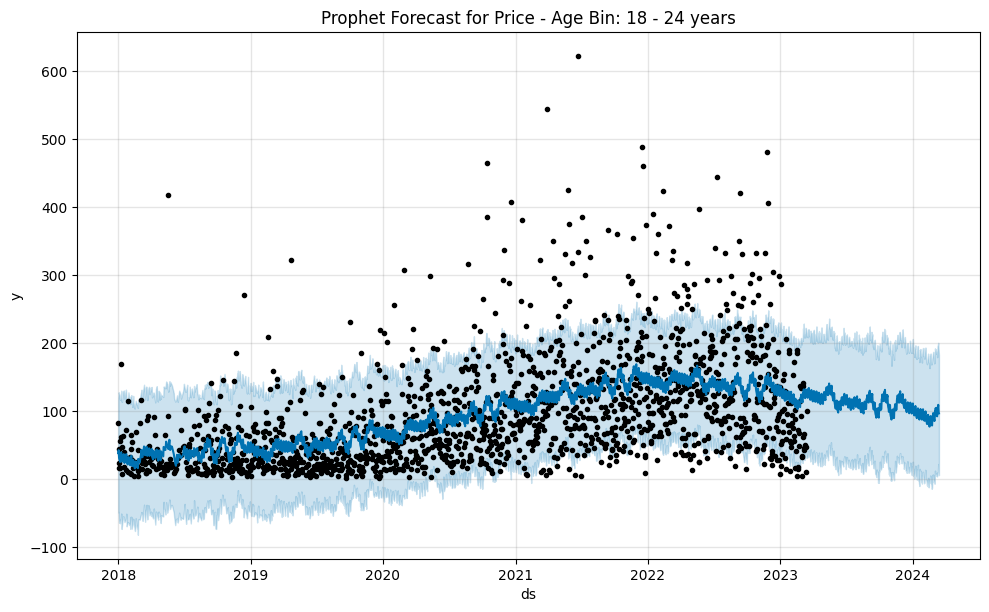

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/f0kmhvta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/pli6ascx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49002', 'data', 'file=/tmp/tmpxzflqyg_/f0kmhvta.json', 'init=/tmp/tmpxzflqyg_/pli6ascx.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model5ulhpbjo/prophet_model-20241216155620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


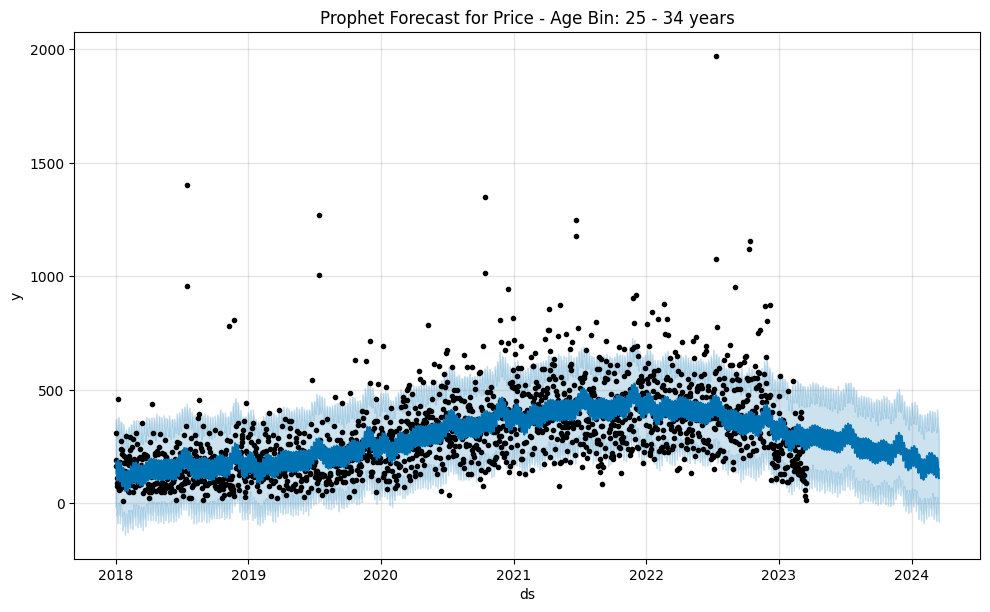

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/_6fhqd4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/7a3044ml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56230', 'data', 'file=/tmp/tmpxzflqyg_/_6fhqd4i.json', 'init=/tmp/tmpxzflqyg_/7a3044ml.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelas8rqbju/prophet_model-20241216155622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


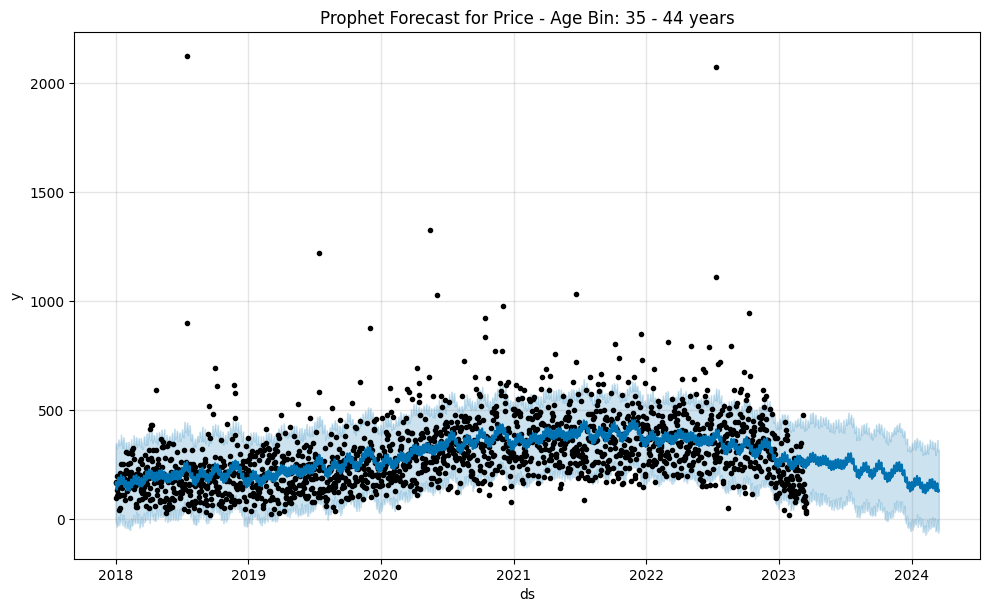

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/uoa_bqvf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/qesx976x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14264', 'data', 'file=/tmp/tmpxzflqyg_/uoa_bqvf.json', 'init=/tmp/tmpxzflqyg_/qesx976x.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model6tzao7fx/prophet_model-20241216155623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


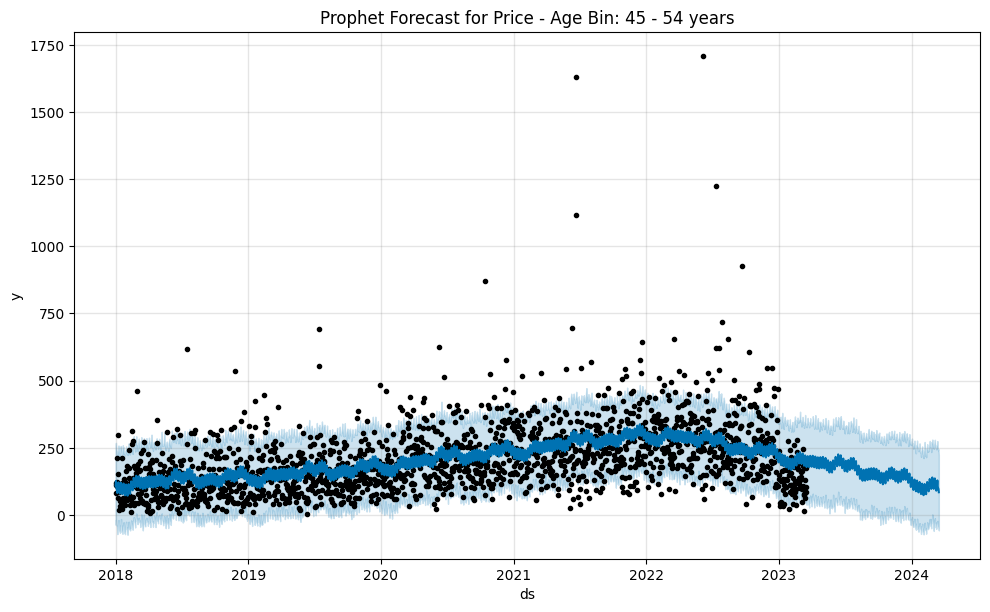

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/gsapeyv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/xf_l5sm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88189', 'data', 'file=/tmp/tmpxzflqyg_/gsapeyv5.json', 'init=/tmp/tmpxzflqyg_/xf_l5sm_.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model735dz4mw/prophet_model-20241216155624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


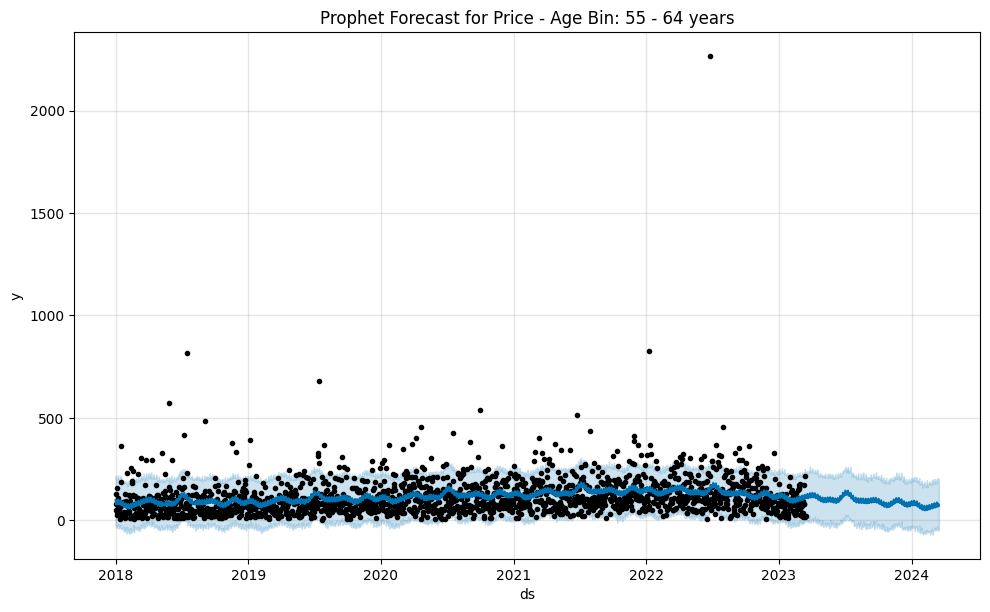

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/nl6yc_ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/e0lxdvh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97149', 'data', 'file=/tmp/tmpxzflqyg_/nl6yc_ff.json', 'init=/tmp/tmpxzflqyg_/e0lxdvh0.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelx2ryeg7m/prophet_model-20241216155625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


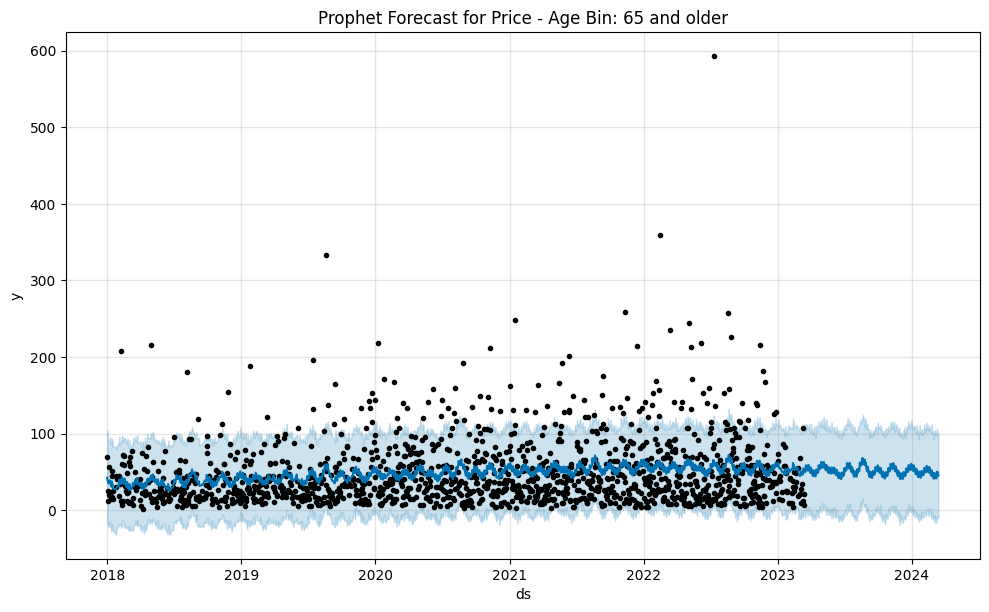

In [ ]:
#Prophet based on age bins, for price(for a given day)
import matplotlib.pyplot as plt
from prophet import Prophet

age_bins = ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 and older']
sorted_age_bins = sorted(age_bins, key=lambda x: int(x.split(' ')[0]))

for age_bin in sorted_age_bins:
    filtered_age_bin = combined_data[combined_data['Q.demos.age'] == age_bin]
    filtered_age_bin_grouped = filtered_age_bin.groupby('Order.Date').agg({
        'Purchase.Price.Per.Unit': 'sum'
    }).reset_index()

    prophet_df_price = filtered_age_bin_grouped[['Order.Date', 'Purchase.Price.Per.Unit']]
    prophet_df_price.columns = ['ds', 'y']


    prophet_model_price = Prophet()
    prophet_model_price.fit(prophet_df_price)
    future_price = prophet_model_price.make_future_dataframe(periods=365)
    forecast_price = prophet_model_price.predict(future_price)

    prophet_model_price.plot(forecast_price)
    plt.title(f'Prophet Forecast for Price - Age Bin: {age_bin}')
    plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/m9cxx9_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/cbi3ezr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98566', 'data', 'file=/tmp/tmpxzflqyg_/m9cxx9_i.json', 'init=/tmp/tmpxzflqyg_/cbi3ezr8.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modeleip6ebya/prophet_model-20241216155636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


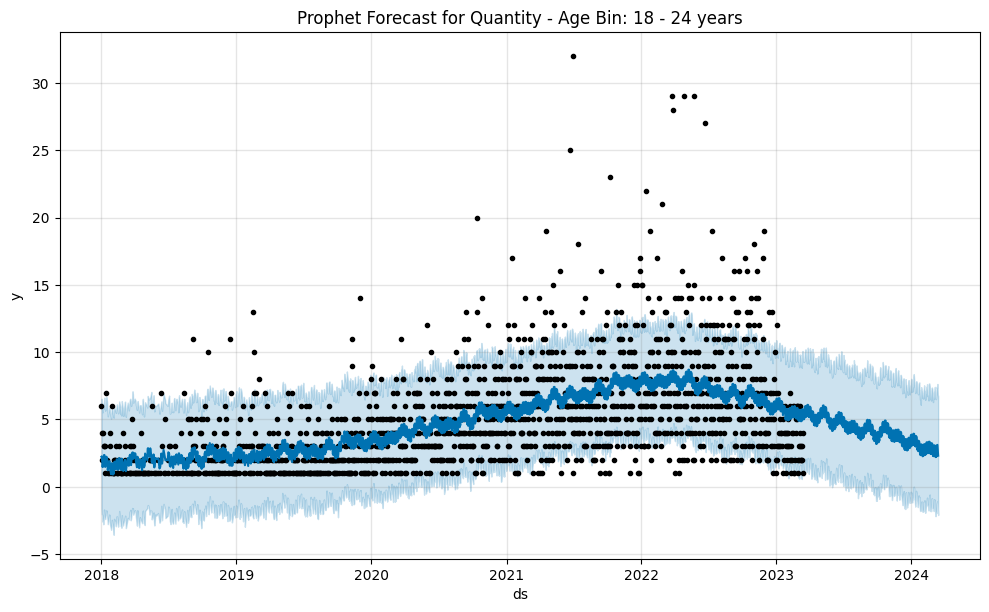

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/g0gpg7nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/qbjvjjfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4467', 'data', 'file=/tmp/tmpxzflqyg_/g0gpg7nf.json', 'init=/tmp/tmpxzflqyg_/qbjvjjfw.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelvhyt3dwa/prophet_model-20241216155638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


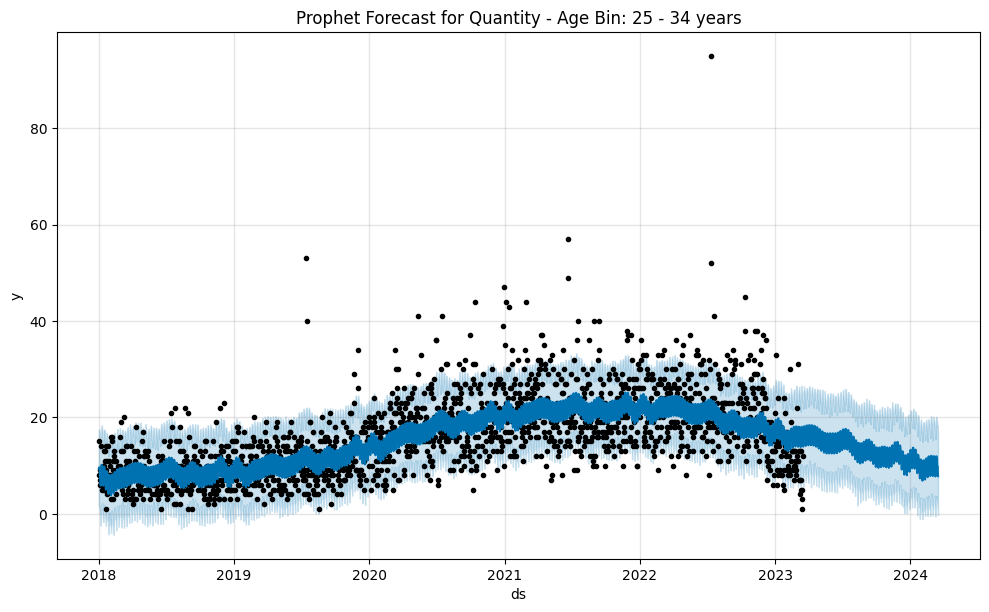

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/3uqzgv5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/xduc346j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48695', 'data', 'file=/tmp/tmpxzflqyg_/3uqzgv5l.json', 'init=/tmp/tmpxzflqyg_/xduc346j.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelioum989l/prophet_model-20241216155639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


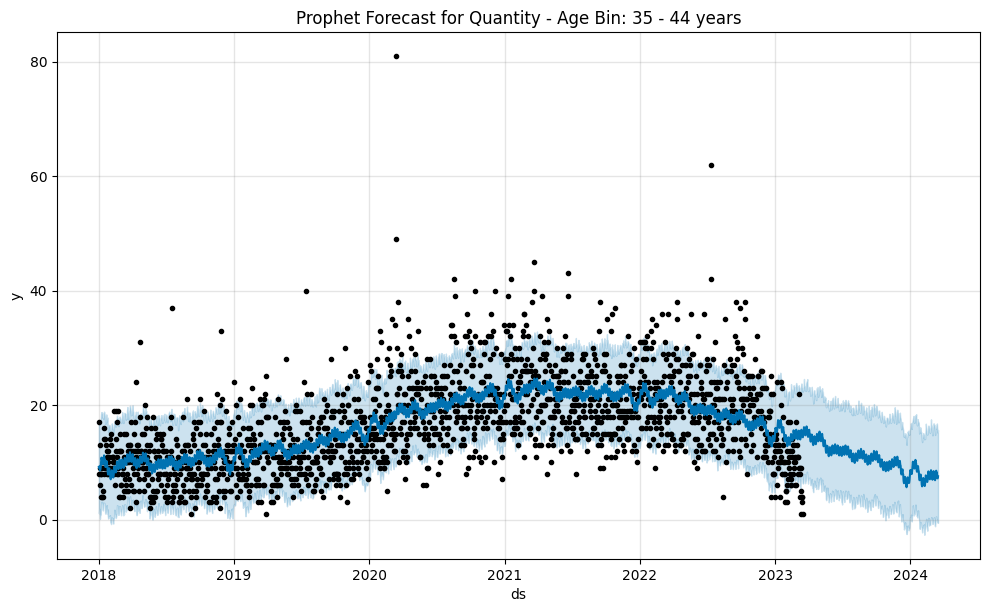

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/md74hkr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/8tb854bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35617', 'data', 'file=/tmp/tmpxzflqyg_/md74hkr3.json', 'init=/tmp/tmpxzflqyg_/8tb854bd.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model2z2s67j2/prophet_model-20241216155640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


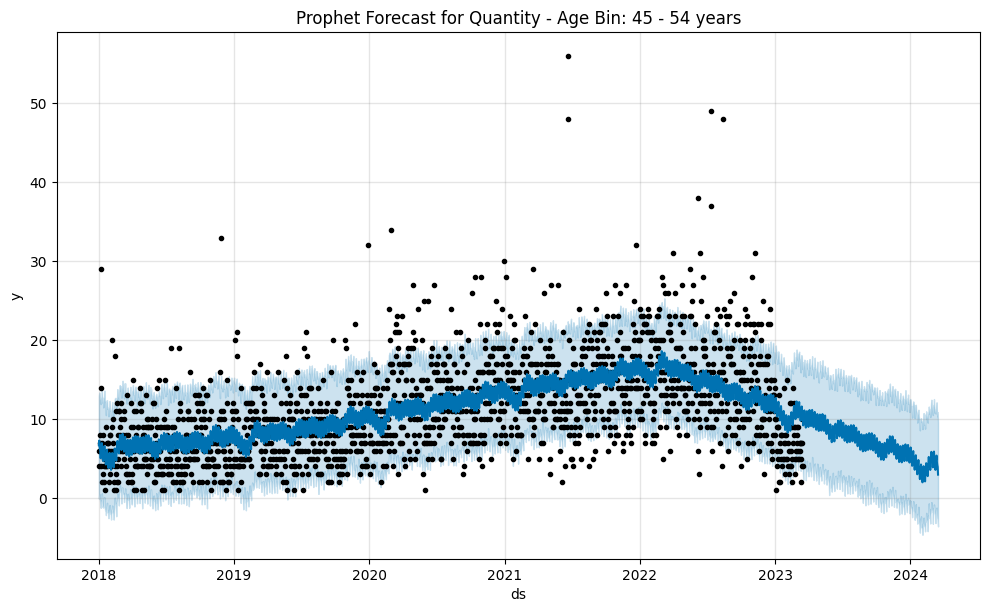

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/n0vz7smz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/jlh3pj84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82070', 'data', 'file=/tmp/tmpxzflqyg_/n0vz7smz.json', 'init=/tmp/tmpxzflqyg_/jlh3pj84.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model1jw272j5/prophet_model-20241216155642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


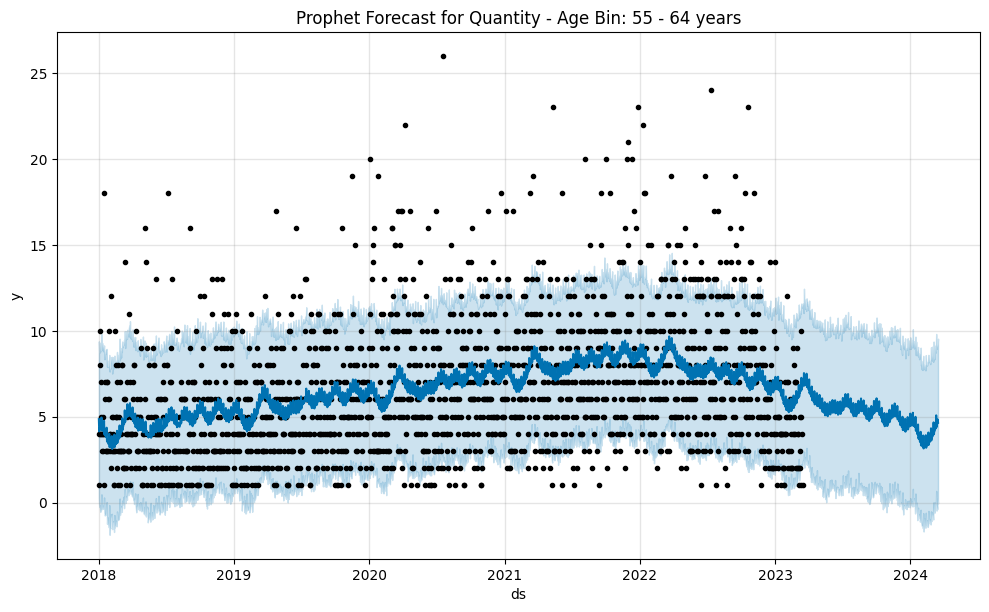

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/dj8l7n7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/vfpmwz46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24489', 'data', 'file=/tmp/tmpxzflqyg_/dj8l7n7l.json', 'init=/tmp/tmpxzflqyg_/vfpmwz46.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modeljx2d9_0l/prophet_model-20241216155644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


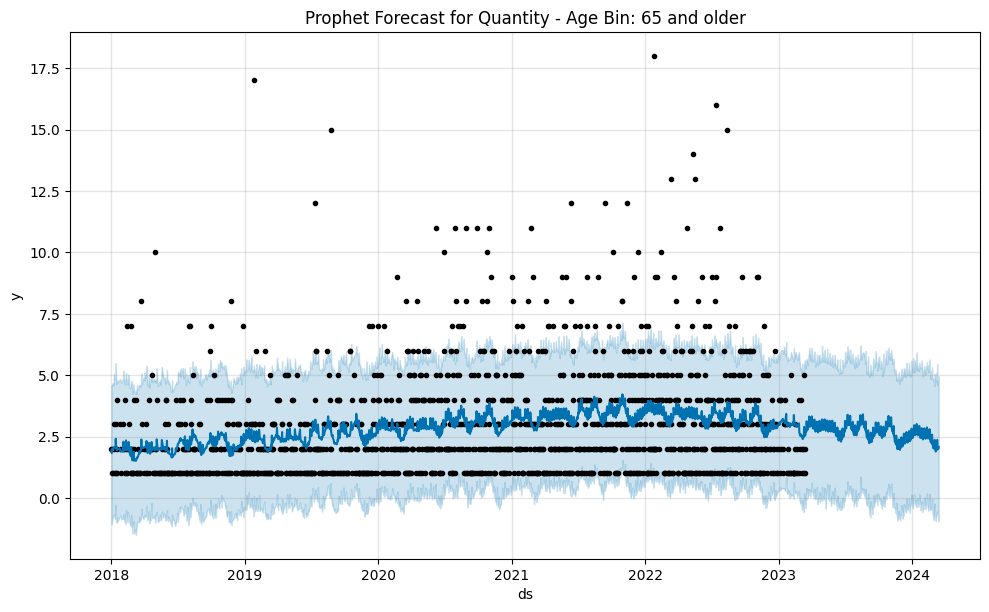

In [ ]:
#prophet for age bins, for no of purchases(for a given day)
import matplotlib.pyplot as plt
from prophet import Prophet

age_bins = ['18 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 and older']
sorted_age_bins = sorted(age_bins, key=lambda x: int(x.split(' ')[0]))

for age_bin in sorted_age_bins:
    filtered_age_bin = combined_data[combined_data['Q.demos.age'] == age_bin]
    filtered_age_bin_grouped = filtered_age_bin.groupby('Order.Date').agg({
        'Quantity': 'sum'
    }).reset_index()
    prophet_df_quantity = filtered_age_bin_grouped[['Order.Date', 'Quantity']]
    prophet_df_quantity.columns = ['ds', 'y']

    prophet_model_quantity = Prophet()
    prophet_model_quantity.fit(prophet_df_quantity)
    future_quantity = prophet_model_quantity.make_future_dataframe(periods=365)
    forecast_quantity = prophet_model_quantity.predict(future_quantity)

    prophet_model_quantity.plot(forecast_quantity)
    plt.title(f'Prophet Forecast for Quantity - Age Bin: {age_bin}')
    plt.show()


In [ ]:
#counts for races
race_counts = combined_data['Q.demos.race'].value_counts().sort_values(ascending=False)
print(race_counts)

Q.demos.race
White or Caucasian                                                                               81860
Asian                                                                                             5360
Black or African American                                                                         5341
White or Caucasian,Asian                                                                          1576
White or Caucasian,American Indian/Native American or Alaska Native                               1503
Other                                                                                             1363
White or Caucasian,Black or African American                                                      1205
White or Caucasian,Other                                                                           446
White or Caucasian,Black or African American,American Indian/Native American or Alaska Native      409
American Indian/Native American or Alaska Native            

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/4esbkkx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/2eha8ubq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30380', 'data', 'file=/tmp/tmpxzflqyg_/4esbkkx6.json', 'init=/tmp/tmpxzflqyg_/2eha8ubq.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelidui9nyo/prophet_model-20241216155701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


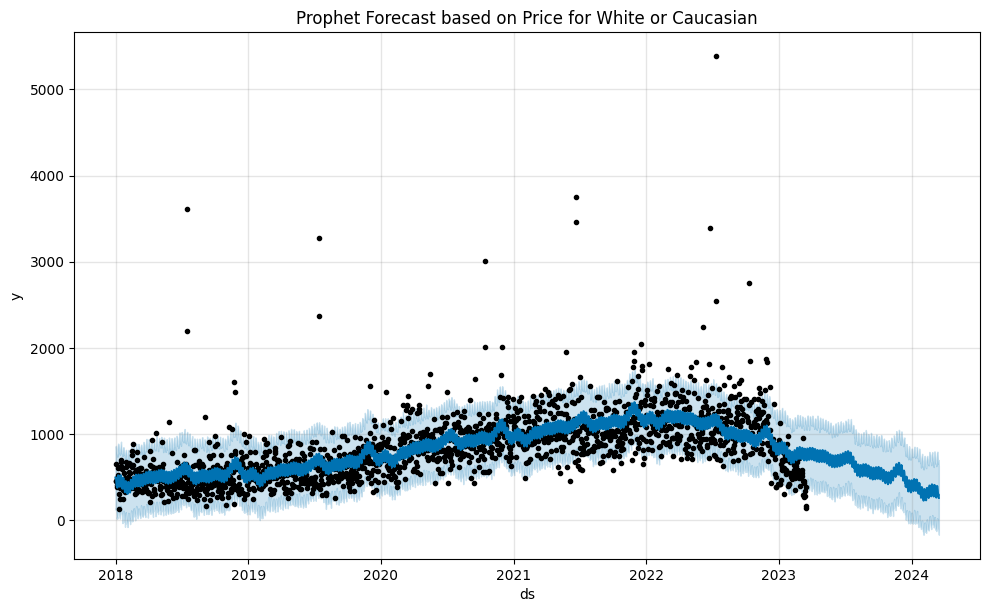

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/fs6ia43q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/reojlpnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62108', 'data', 'file=/tmp/tmpxzflqyg_/fs6ia43q.json', 'init=/tmp/tmpxzflqyg_/reojlpnq.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model5500jqm_/prophet_model-20241216155702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


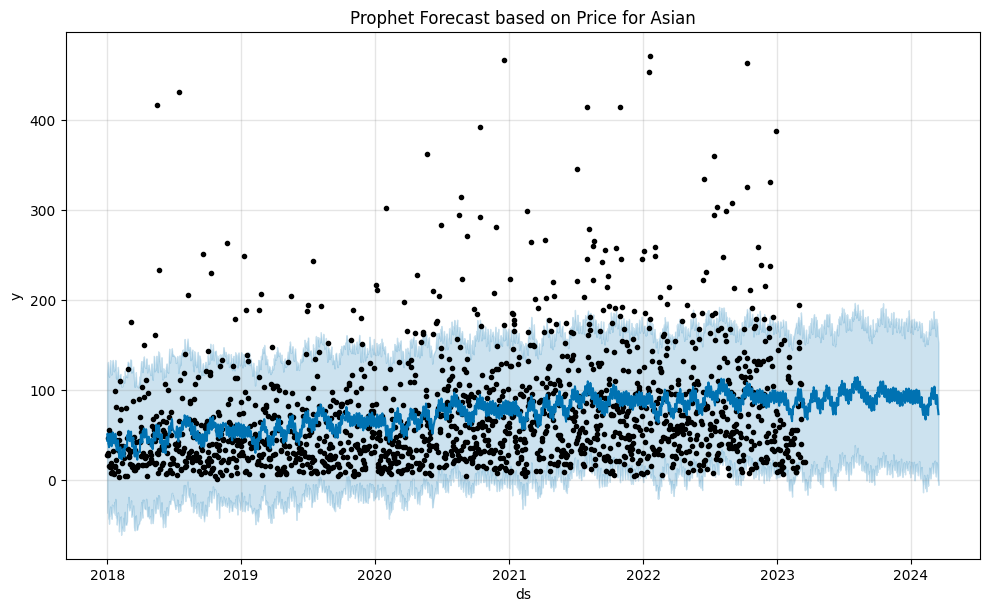

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/4crwd88y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/cjlep7sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53410', 'data', 'file=/tmp/tmpxzflqyg_/4crwd88y.json', 'init=/tmp/tmpxzflqyg_/cjlep7sp.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modeln2s7i4dw/prophet_model-20241216155703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


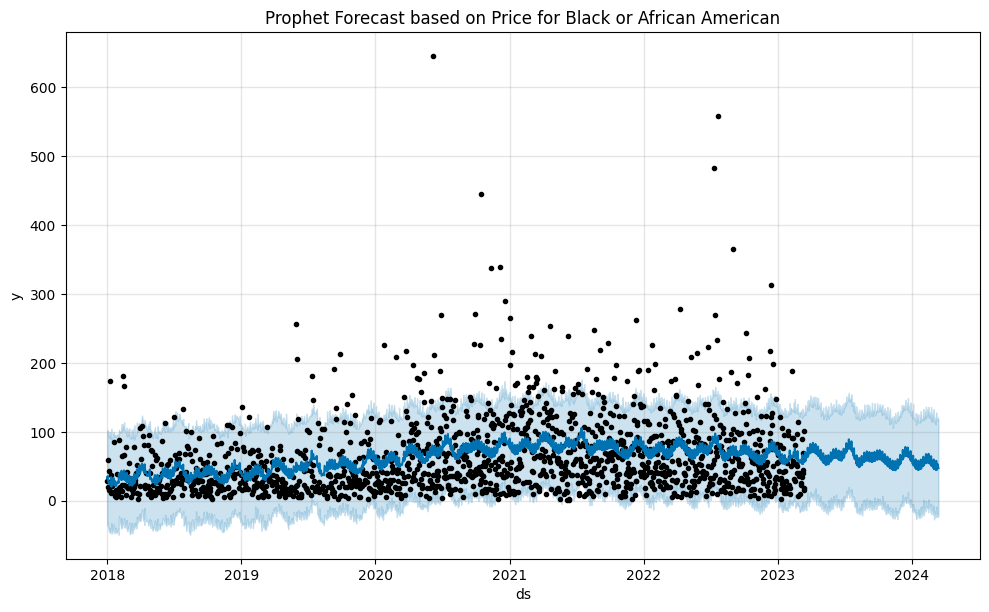

In [ ]:
#Prophet based on race,price(for a given day)
from prophet import Prophet
import matplotlib.pyplot as plt

top_races = ['White or Caucasian', 'Asian', 'Black or African American']
filtered_data = combined_data[combined_data['Q.demos.race'].isin(top_races)]
race_grouped = filtered_data.groupby(['Q.demos.race', 'Order.Date']).agg({
    'Purchase.Price.Per.Unit': 'sum'
}).reset_index()

for race in top_races:
    race_data = race_grouped[race_grouped['Q.demos.race'] == race]

    prophet_df_price = race_data[['Order.Date', 'Purchase.Price.Per.Unit']].reset_index(drop=True)
    prophet_df_price.columns = ['ds', 'y']

    prophet_model_price = Prophet()
    prophet_model_price.fit(prophet_df_price)
    future_price = prophet_model_price.make_future_dataframe(periods=365)
    forecast_price = prophet_model_price.predict(future_price)

    prophet_model_price.plot(forecast_price)
    plt.title(f'Prophet Forecast based on Price for {race}')
    plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/1ir4ksf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/hvle_bm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41621', 'data', 'file=/tmp/tmpxzflqyg_/1ir4ksf2.json', 'init=/tmp/tmpxzflqyg_/hvle_bm1.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelt_l7sb68/prophet_model-20241216155712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


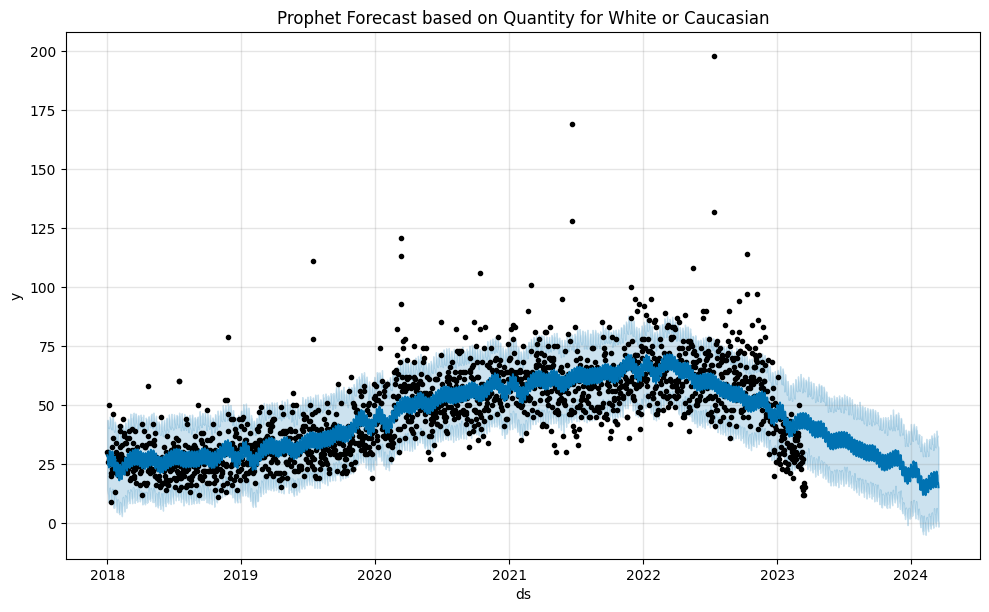

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/10gm78g3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/ojuvtd0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60403', 'data', 'file=/tmp/tmpxzflqyg_/10gm78g3.json', 'init=/tmp/tmpxzflqyg_/ojuvtd0_.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model_j47jxal/prophet_model-20241216155714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


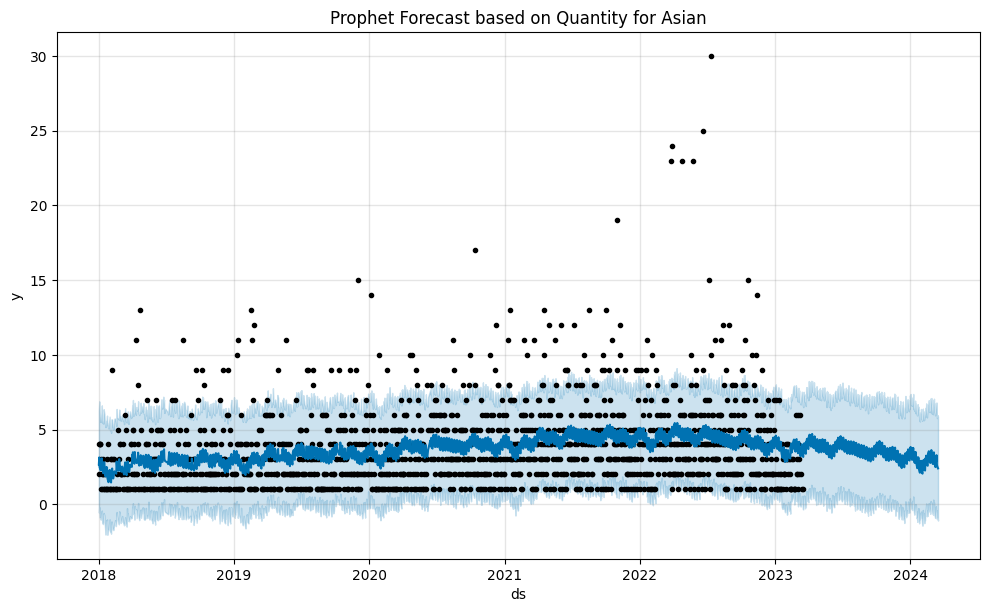

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/vrxhtsrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/rpldw316.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52217', 'data', 'file=/tmp/tmpxzflqyg_/vrxhtsrs.json', 'init=/tmp/tmpxzflqyg_/rpldw316.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model3ae6iubg/prophet_model-20241216155715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


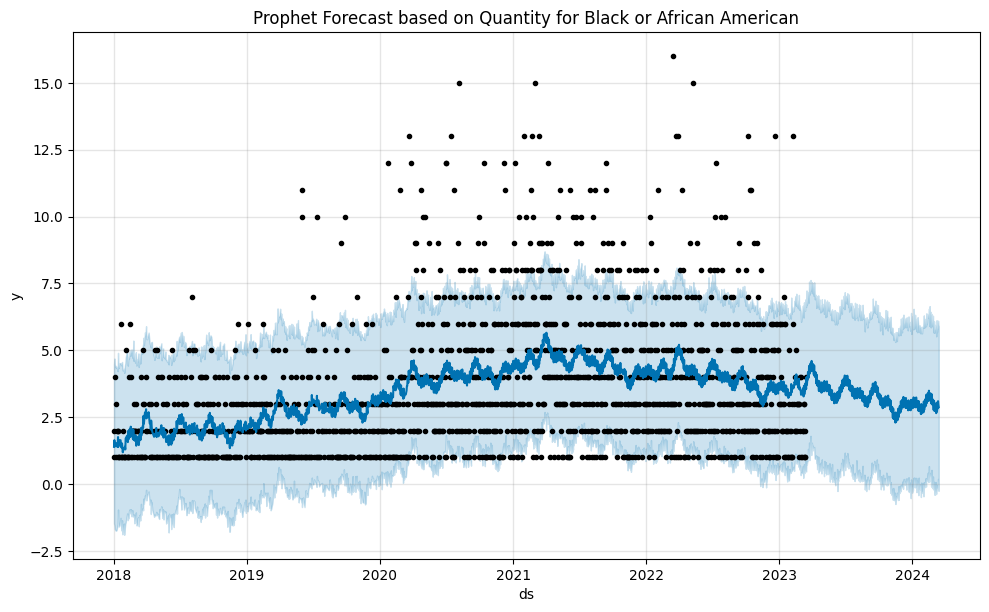

In [ ]:
#Prophet based on race,for quantiy(for a given day)
from prophet import Prophet
import matplotlib.pyplot as plt

top_races = ['White or Caucasian', 'Asian', 'Black or African American']
filtered_data = combined_data[combined_data['Q.demos.race'].isin(top_races)]
race_grouped = filtered_data.groupby(['Q.demos.race', 'Order.Date']).agg({
    'Quantity': 'sum'
}).reset_index()

for race in top_races:
    race_data = race_grouped[race_grouped['Q.demos.race'] == race]
    prophet_df_quantity = race_data[['Order.Date', 'Quantity']].reset_index(drop=True)
    prophet_df_quantity.columns = ['ds', 'y']

    prophet_model_quantity = Prophet()
    prophet_model_quantity.fit(prophet_df_quantity)
    future_quantity = prophet_model_quantity.make_future_dataframe(periods=365)
    forecast_quantity = prophet_model_quantity.predict(future_quantity)

    prophet_model_quantity.plot(forecast_quantity)
    plt.title(f'Prophet Forecast based on Quantity for {race}')
    plt.show()


In [ ]:
income_counts = combined_data['Q.demos.income'].value_counts().sort_values(ascending=False)
print(income_counts)


Q.demos.income
$25,000 - $49,999      20332
$50,000 - $74,999      20100
$100,000 - $149,999    19264
$75,000 - $99,999      17105
$150,000 or more       12682
Less than $25,000       9544
Prefer not to say       1165
Name: count, dtype: int64


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/d1qyixqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/zssva3oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56835', 'data', 'file=/tmp/tmpxzflqyg_/d1qyixqy.json', 'init=/tmp/tmpxzflqyg_/zssva3oz.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelcfrvq_7a/prophet_model-20241216155729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


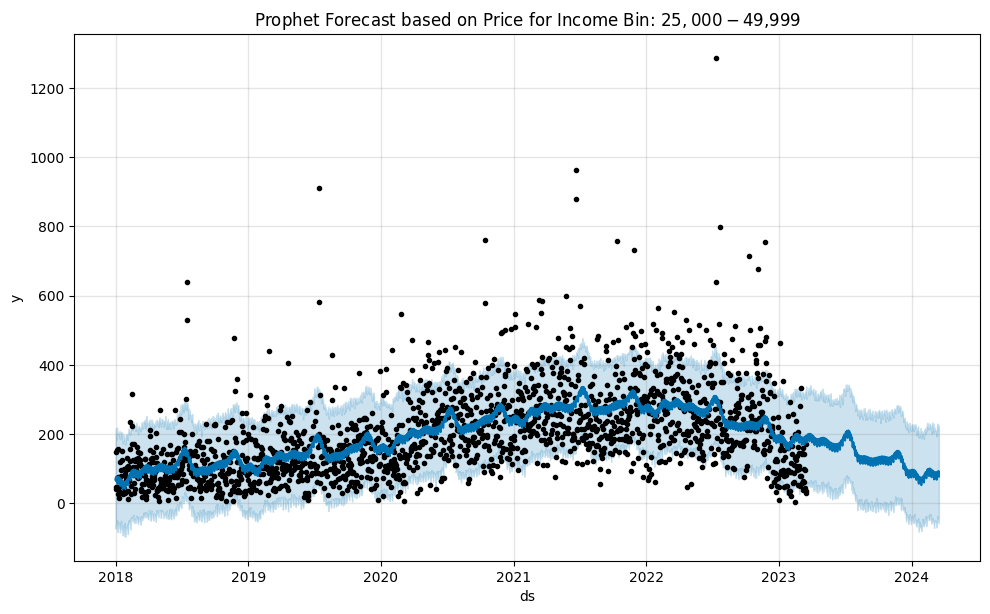

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/zvvyldrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/2b67vpe8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58228', 'data', 'file=/tmp/tmpxzflqyg_/zvvyldrg.json', 'init=/tmp/tmpxzflqyg_/2b67vpe8.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelptjn3uso/prophet_model-20241216155731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


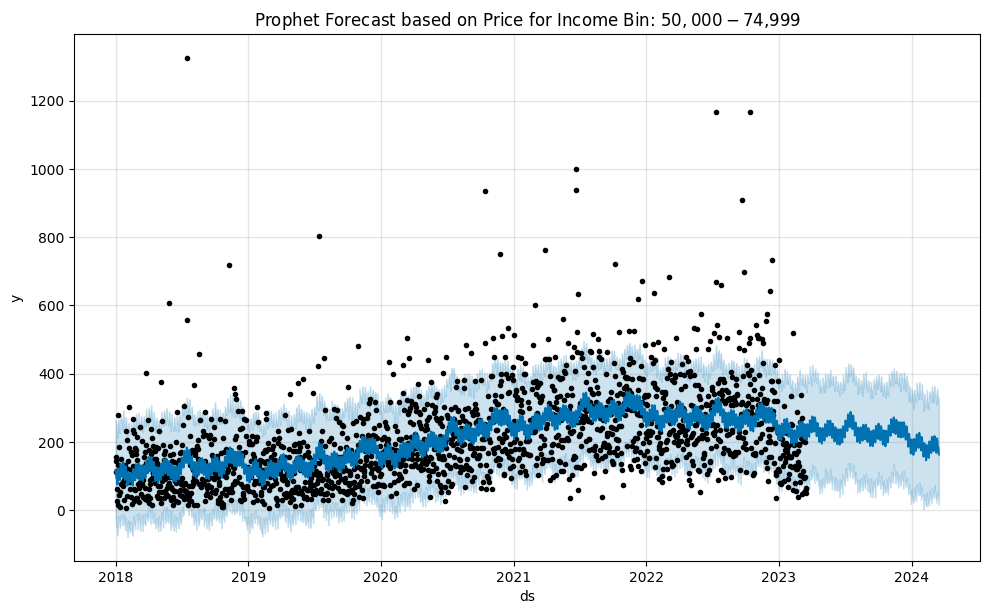

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/ctuqhnir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/0r328959.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6469', 'data', 'file=/tmp/tmpxzflqyg_/ctuqhnir.json', 'init=/tmp/tmpxzflqyg_/0r328959.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelz8t5_y5s/prophet_model-20241216155733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


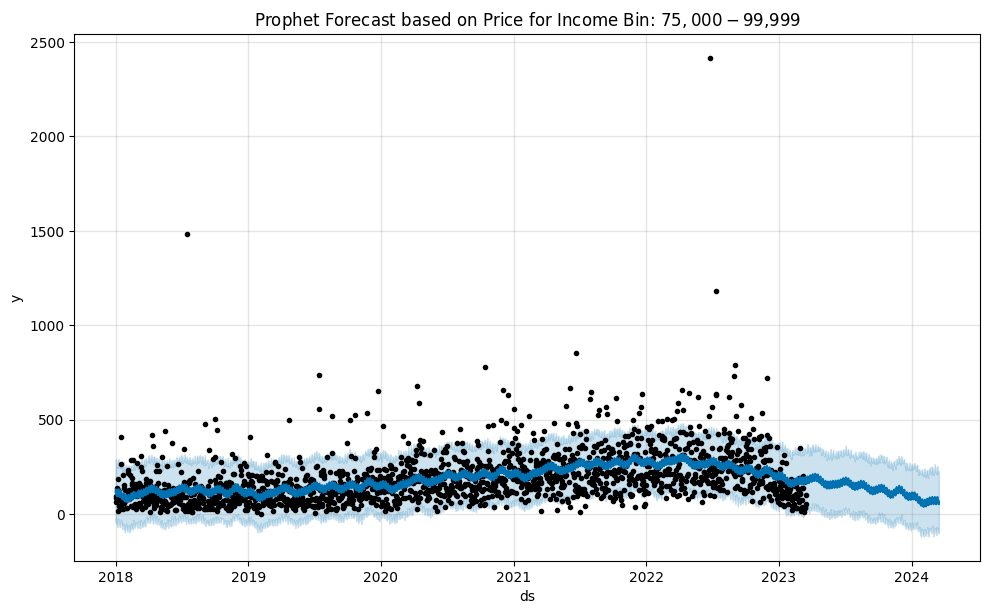

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/ww1v1ai2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/0gmjjzp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83019', 'data', 'file=/tmp/tmpxzflqyg_/ww1v1ai2.json', 'init=/tmp/tmpxzflqyg_/0gmjjzp0.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelquin4f7_/prophet_model-20241216155734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


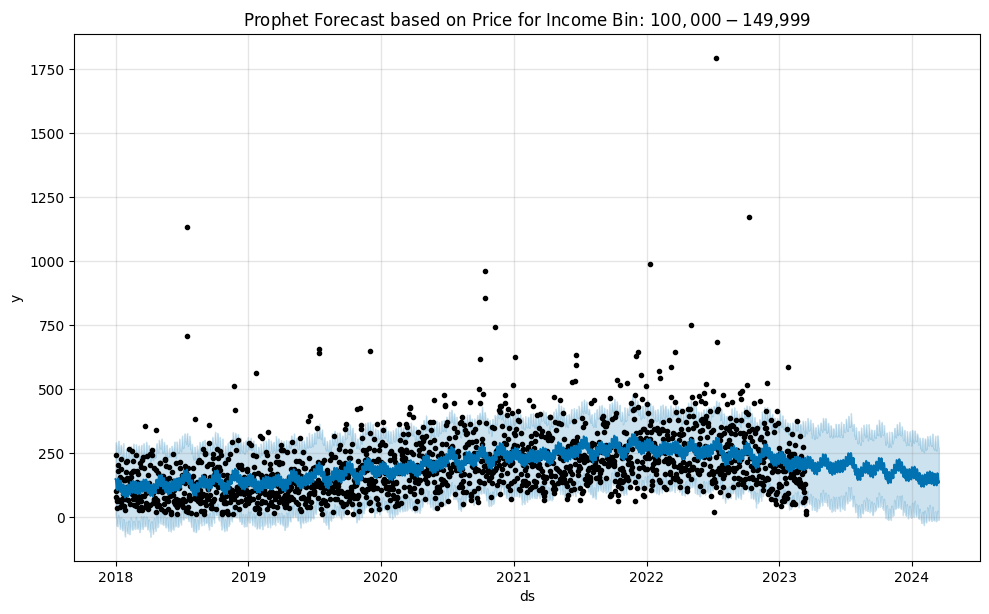

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/7nh98js0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/xz7jkfz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14700', 'data', 'file=/tmp/tmpxzflqyg_/7nh98js0.json', 'init=/tmp/tmpxzflqyg_/xz7jkfz8.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modeljswv1zt0/prophet_model-20241216155736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


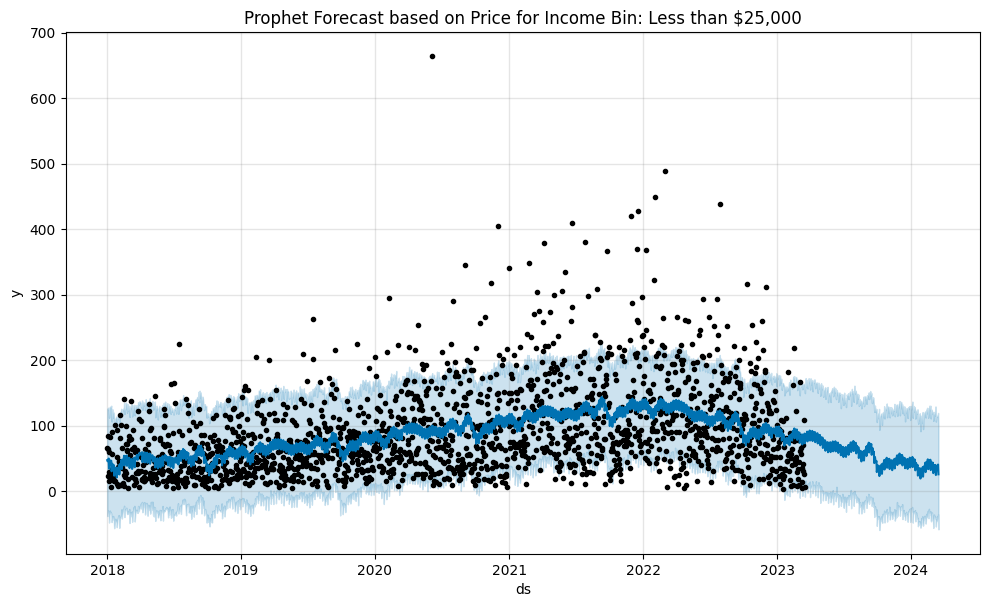

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/_e_wwm5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/zybvg8fq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6482', 'data', 'file=/tmp/tmpxzflqyg_/_e_wwm5i.json', 'init=/tmp/tmpxzflqyg_/zybvg8fq.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model2d5l49d5/prophet_model-20241216155737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


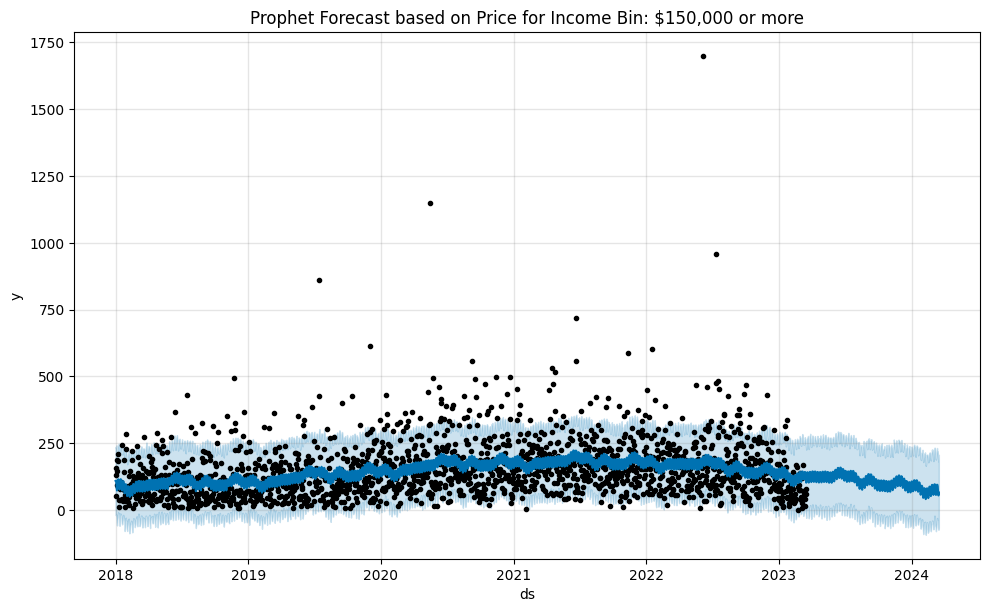

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/85str3go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/188sy156.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1954', 'data', 'file=/tmp/tmpxzflqyg_/85str3go.json', 'init=/tmp/tmpxzflqyg_/188sy156.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model2sopdwrw/prophet_model-20241216155738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


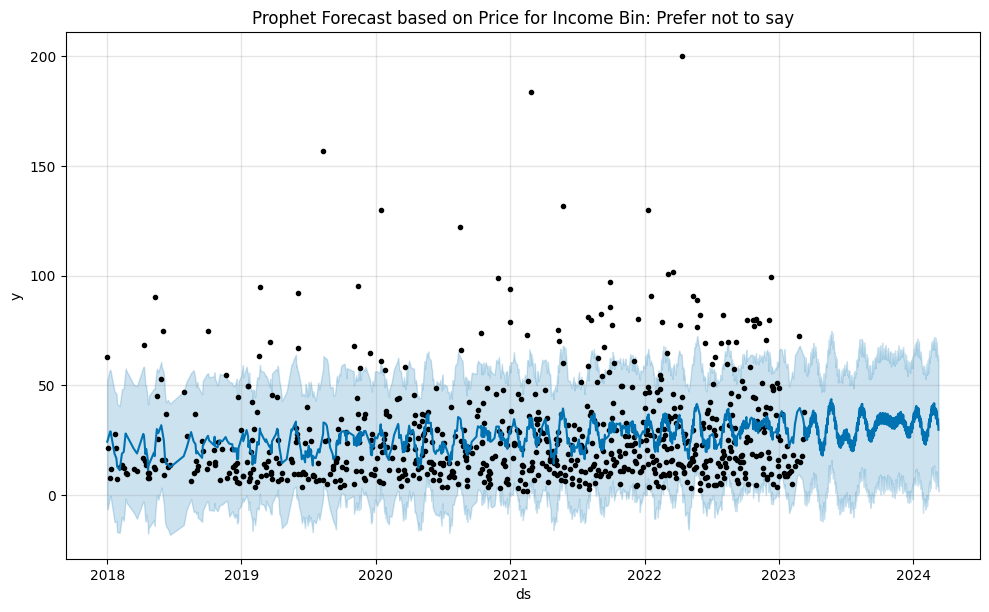

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

income_bins = combined_data['Q.demos.income'].unique()
income_grouped = combined_data.groupby(['Q.demos.income', 'Order.Date']).agg({
    'Purchase.Price.Per.Unit': 'sum'
}).reset_index()

for income_bin in income_bins:

    income_data = income_grouped[income_grouped['Q.demos.income'] == income_bin]
    prophet_df_price = income_data[['Order.Date', 'Purchase.Price.Per.Unit']].reset_index(drop=True)
    prophet_df_price.columns = ['ds', 'y']

    prophet_model_price = Prophet()
    prophet_model_price.fit(prophet_df_price)
    future_price = prophet_model_price.make_future_dataframe(periods=365)
    forecast_price = prophet_model_price.predict(future_price)

    prophet_model_price.plot(forecast_price)
    plt.title(f'Prophet Forecast based on Price for Income Bin: {income_bin}')
    plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/4r51dncr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/l6s5bhkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19973', 'data', 'file=/tmp/tmpxzflqyg_/4r51dncr.json', 'init=/tmp/tmpxzflqyg_/l6s5bhkk.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modeluxi2ingu/prophet_model-20241216155747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


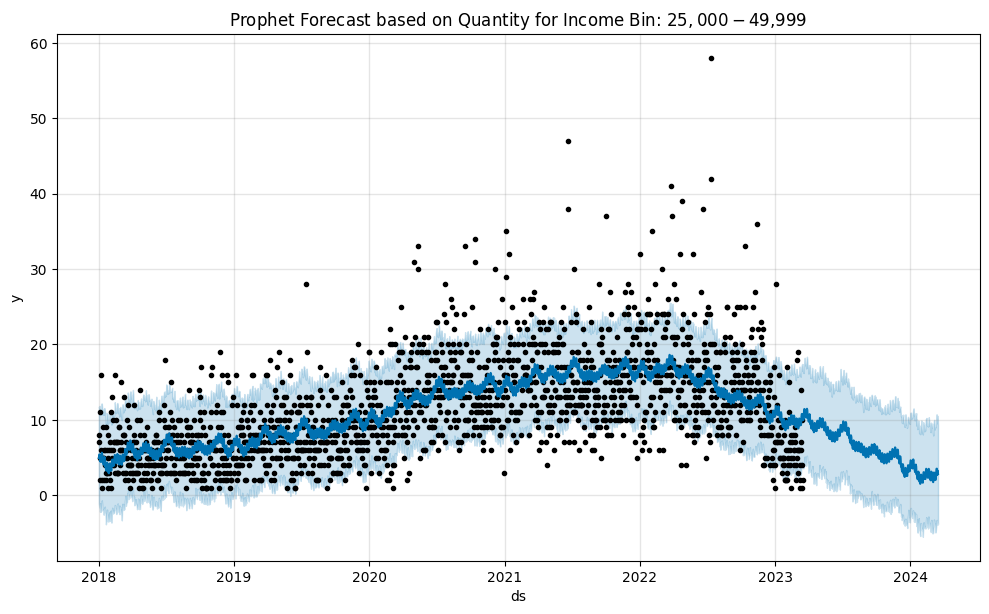

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/vmz4shnk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/055cy9qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37843', 'data', 'file=/tmp/tmpxzflqyg_/vmz4shnk.json', 'init=/tmp/tmpxzflqyg_/055cy9qg.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelri35g1xa/prophet_model-20241216155749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


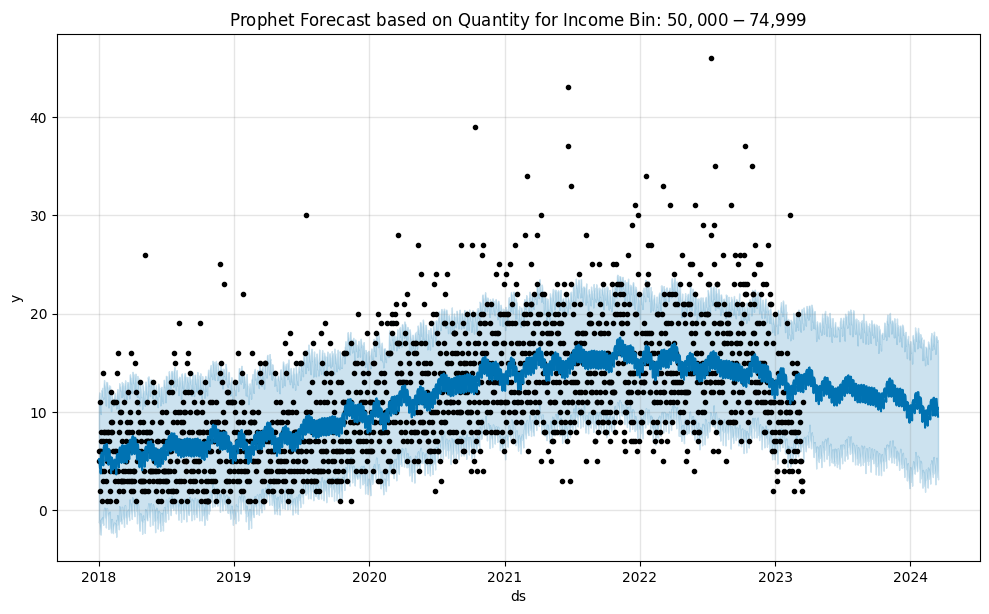

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/g75xatrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/zozv7q96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81473', 'data', 'file=/tmp/tmpxzflqyg_/g75xatrx.json', 'init=/tmp/tmpxzflqyg_/zozv7q96.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model8ifhpfjk/prophet_model-20241216155750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


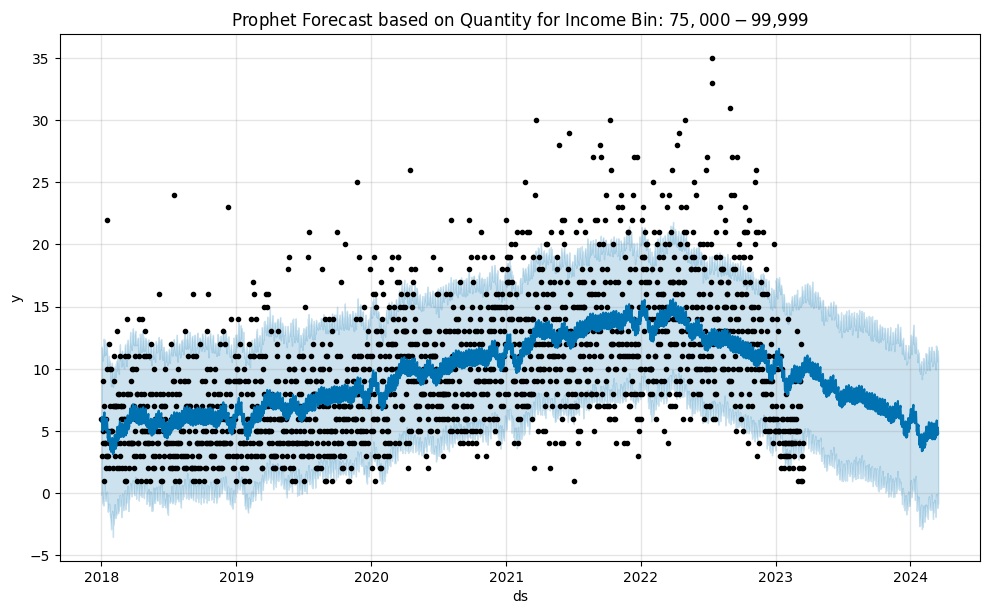

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/bkho66sk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/k8syn6px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97845', 'data', 'file=/tmp/tmpxzflqyg_/bkho66sk.json', 'init=/tmp/tmpxzflqyg_/k8syn6px.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelsp76imbj/prophet_model-20241216155751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


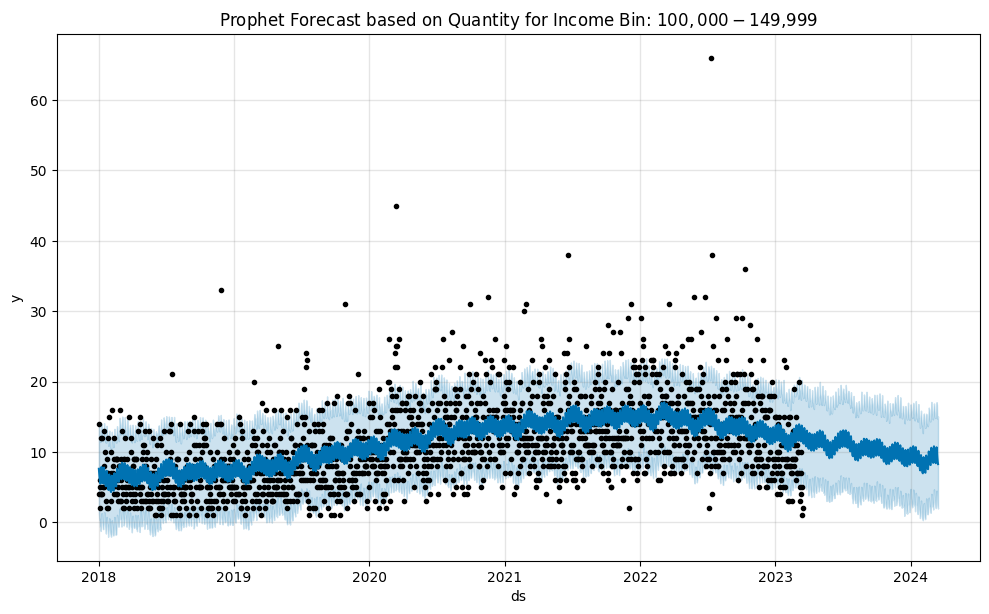

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/o_iatu91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/qlulotsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31686', 'data', 'file=/tmp/tmpxzflqyg_/o_iatu91.json', 'init=/tmp/tmpxzflqyg_/qlulotsa.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelbmtsz_36/prophet_model-20241216155753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


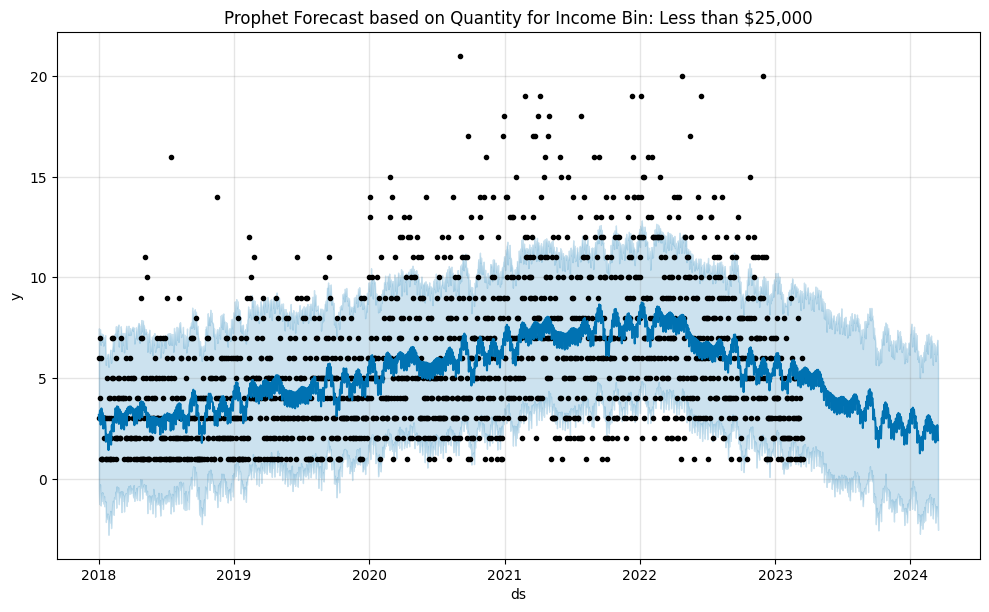

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/dqrc4qci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/u7efvsmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85704', 'data', 'file=/tmp/tmpxzflqyg_/dqrc4qci.json', 'init=/tmp/tmpxzflqyg_/u7efvsmu.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_modelhxet59fo/prophet_model-20241216155754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


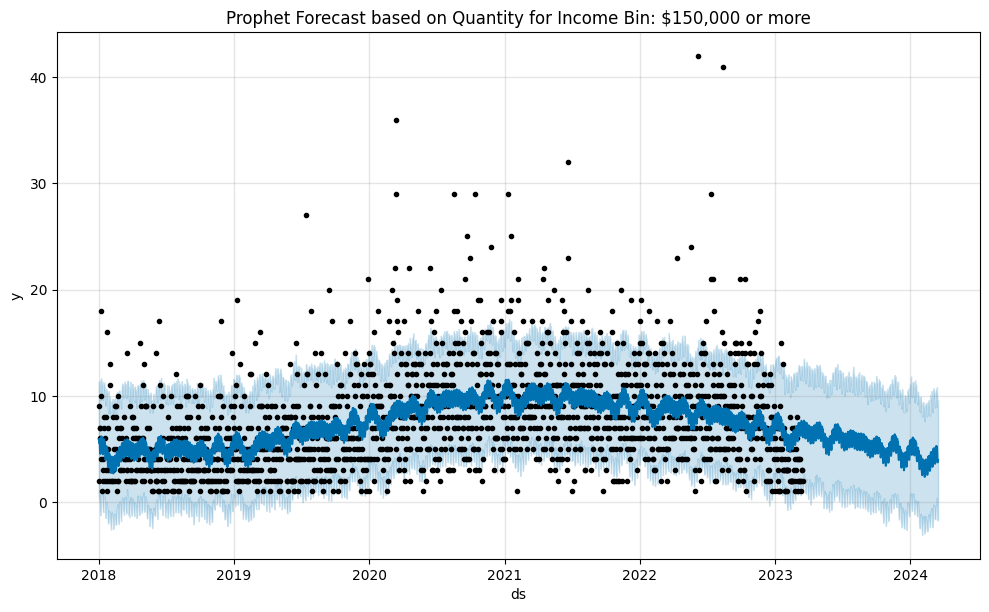

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/0he_kvsg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzflqyg_/rfe9l1gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50147', 'data', 'file=/tmp/tmpxzflqyg_/0he_kvsg.json', 'init=/tmp/tmpxzflqyg_/rfe9l1gz.json', 'output', 'file=/tmp/tmpxzflqyg_/prophet_model5b5mkvts/prophet_model-20241216155756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


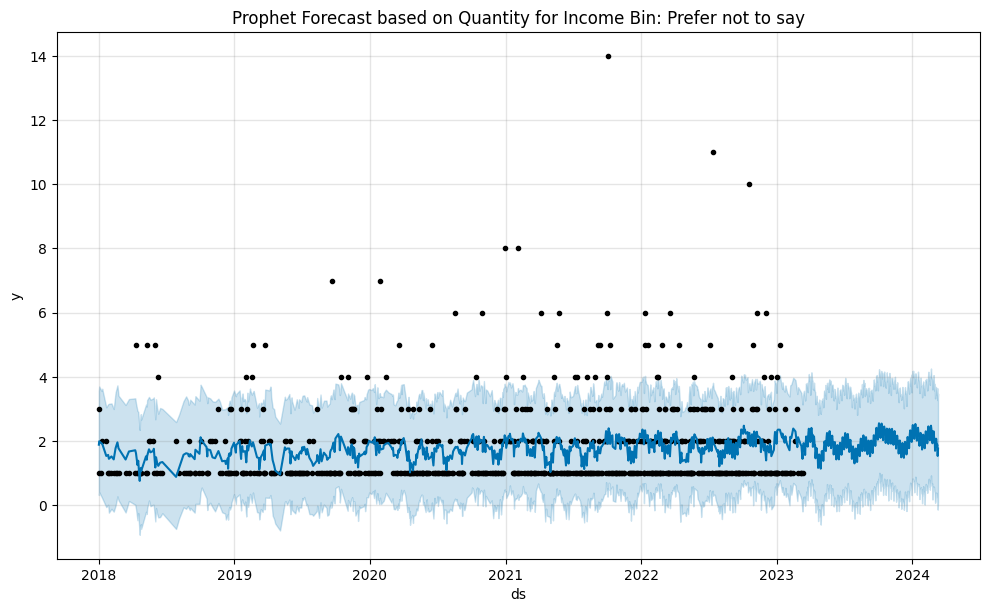

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

income_bins = combined_data['Q.demos.income'].unique()
income_grouped = combined_data.groupby(['Q.demos.income', 'Order.Date']).agg({
    'Quantity': 'sum'
}).reset_index()

for income_bin in income_bins:

    income_data = income_grouped[income_grouped['Q.demos.income'] == income_bin]
    prophet_df_quantity = income_data[['Order.Date', 'Quantity']].reset_index(drop=True)
    prophet_df_quantity.columns = ['ds', 'y']

    prophet_model_quantity = Prophet()
    prophet_model_quantity.fit(prophet_df_quantity)
    future_quantity = prophet_model_quantity.make_future_dataframe(periods=365)
    forecast_quantity = prophet_model_quantity.predict(future_quantity)

    prophet_model_quantity.plot(forecast_quantity)
    plt.title(f'Prophet Forecast based on Quantity for Income Bin: {income_bin}')
    plt.show()
